In [4]:
import pymc as pm
import numpy as np
import pandas as pd
from string import ascii_lowercase
from nltk.tokenize import word_tokenize
import os
import re
from nltk.stem import PorterStemmer
from pathlib import Path
from urllib.parse import urlparse 
from concurrent.futures import ThreadPoolExecutor 
import multiprocessing 
from queue import Queue, Empty 
import pickle
import requests
from elasticsearch import Elasticsearch
from pathlib import Path
import os
import json
import pickle

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Page 42-48

In [12]:
class Indexer:
    def __init__(self):
        self.crawled_folder = Path(os.path.abspath('')).parent / 'crawled/'
        with open(self.crawled_folder / 'url_list.pickle', 'rb') as f:
            self.file_mapper = pickle.load(f)
        self.es_client = Elasticsearch(
            "https://localhost:9200",
            basic_auth=("elastic", "D*d4-0+Kl+lxfbbzh5ut"),
            ca_certs="~/http_ca.crt"
        )

    def run_indexer(self):
        # Delete and recreate the 'simple' index
        self.es_client.options(ignore_status=[400, 404]).indices.delete(index='simple')
        self.es_client.options(ignore_status=400).indices.create(index='simple')

        # Process each file and index the documents
        for file in os.listdir(self.crawled_folder):
            if file.endswith(".txt"):
                file_path = os.path.join(self.crawled_folder, file)
                with open(file_path, 'r', encoding='utf-8') as f:
                    j = json.load(f)
                j['id'] = j['url']  # Add an 'id' field
                print(j)  # Print document being indexed
                self.es_client.index(index='simple', document=j)

    def search(self, query):
        results = self.es_client.search(index='simple', query=query)
        print("Got %d Hits:" % results['hits']['total']['value'])
        for hit in results['hits']['hits']:
            print("The title is '{0}' ({1}).".format(hit["_source"]["title"], hit["_source"]["url"]))


In [13]:
# Initialize the Indexer and run it
indexer = Indexer()
indexer.run_indexer()

{'url': 'https://www.cmu.ac.th/en/article/31389293-9bac-4cad-9b28-18468a7f30b3', 'title': 'News : Discussion with PEA on Electricity Service Improvement - Chiang Mai University', 'text': "CMU             Curricular    Seperating Faculties    Search for Curriculums    Bachelor’s Degree    Master’s Degree    Doctoral Degree    Other Curriculums     |   Studying at CMU    Application of Bachelor's  Degree    Application for Graduate Studies    Application of International Program    CMU Presidential Scholarship     |   Faculties and Departments    Faculties    CMU’s Organizations    Other Division     |   TH    EN    CN                                 TH  EN  CN     Curricular    Seperating Faculties    Search for Curriculums    Bachelor’s Degree    Master’s Degree    Doctoral Degree    Other Curriculums      Studying at CMU    Application of Bachelor's  Degree    Application for Graduate Studies    Application of International Program    CMU Presidential Scholarship      Faculties and De

In [18]:
# Example queries from Page 43
queries = [
    {'bool': {'must': [{'match': {'text': 'camt'}}]}},
    {'bool': {'must': [{'match': {'text': 'examination'}}]}},
    {"regexp": { "text": ".*vision.*"}},
    {"match": { "text": "vision"}}
]


In [19]:
# Execute queries and display results
for query in queries:
    print(f"Executing query: {query}")
    indexer.search(query)

Executing query: {'bool': {'must': [{'match': {'text': 'camt'}}]}}
Got 16 Hits:
The title is 'วิทยาลัยศิลปะ สื่อ และเทคโนโลยี - มหาวิทยาลัยเชียงใหม่' (https://www.cmu.ac.th/en/faculty/the_college_of_arts_media_and_technology/aboutus).
The title is 'News : CAMT Signs MoU on Academic and Research Development with University of Bremen, Germany - Chiang Mai University' (https://www.cmu.ac.th/en/article/a0db2c1c-60bd-4e0f-a73c-c0390f100577).
The title is 'มหาวิทยาลัยเชียงใหม่ : Chiang Mai University, THAILAND' (https://cmu.ac.th/th/60years).
The title is 'มหาวิทยาลัยเชียงใหม่ : Chiang Mai University, THAILAND' (https://www.cmu.ac.th/th/60years).
The title is 'คณะการสื่อสารมวลชน - มหาวิทยาลัยเชียงใหม่' (https://www.cmu.ac.th/en/faculty/mass_communication/aboutus).
The title is 'มหาวิทยาลัยเชียงใหม่ : Chiang Mai University, THAILAND' (https://www.cmu.ac.th/en/SDGs/4).
The title is 'มหาวิทยาลัยเชียงใหม่ : Chiang Mai University, THAILAND' (https://www.cmu.ac.th/en/articlegroup/c902f832-5354-457

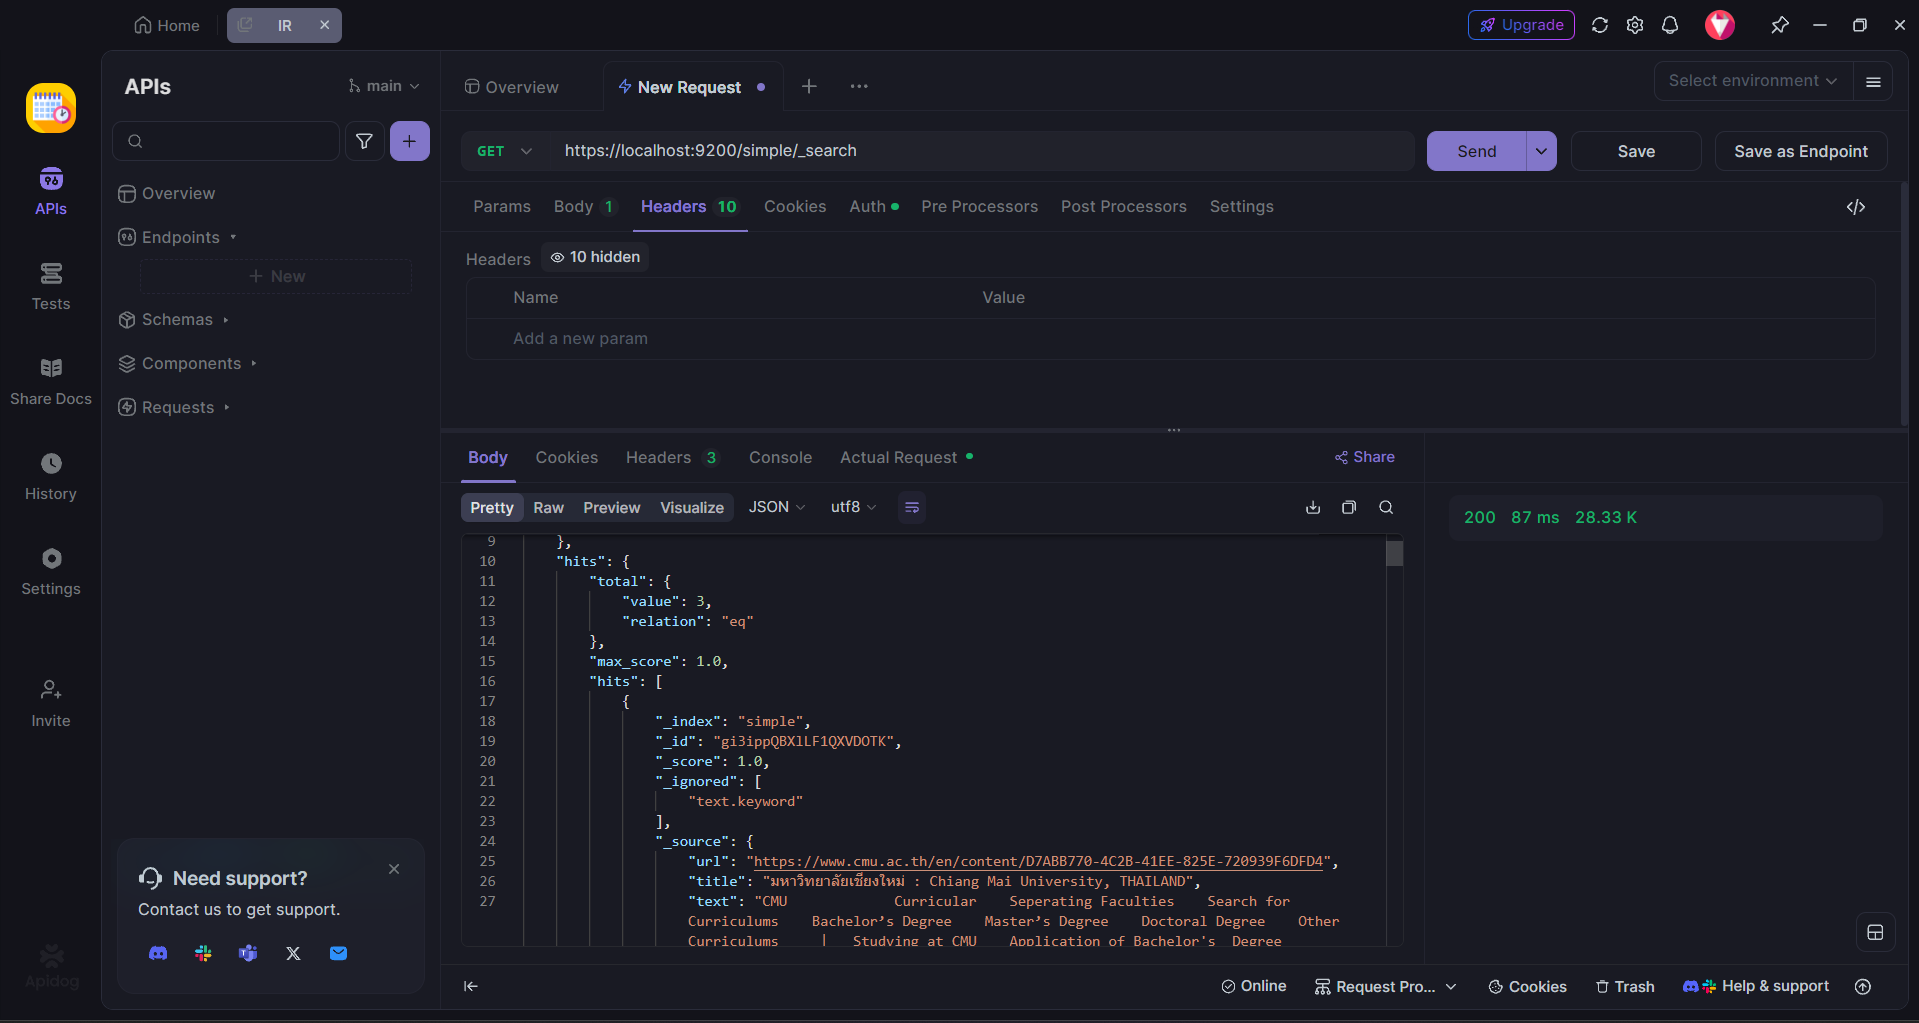

### Page  49 - 50

In [20]:
from flask import Flask, request
import time

In [26]:
from flask import Flask, request
from elasticsearch import Elasticsearch
import pandas as pd
import time

# Initialize Flask app
app = Flask(__name__)

# Connect to Elasticsearch
app.es_client = Elasticsearch(
    "https://localhost:9200",
    basic_auth=("elastic", "D*d4-0+Kl+lxfbbzh5ut"),  # Replace with your password
    ca_certs="~/http_ca.crt"  # Adjust the path to your certificate if needed
)

# Define the search endpoint
@app.route('/search_es', methods=['GET'])
def search_es():
    # Record start time for query execution
    start = time.time()
    response_object = {'status': 'success'}
    
    # Get the search query from request arguments
    argList = request.args.to_dict(flat=False)
    query_term = argList['query'][0]
    
    # Perform the search on Elasticsearch
    results = app.es_client.search(
        index='simple',
        source_excludes=['url_lists'],  # Exclude unnecessary fields
        size=100,  # Limit the results to 100
        query={"match": {"text": query_term}}  # Match query on the 'text' field
    )
    
    # Record end time for query execution
    end = time.time()
    total_hit = results['hits']['total']['value']
    
    # Prepare results in a DataFrame
    results_df = pd.DataFrame(
        [
            [
                hit["_source"]['title'],  # Title of the document
                hit["_source"]['url'],  # URL of the document
                hit["_source"]['text'][:100],  # First 100 characters of text
                hit["_score"]  # Relevance score
            ]
            for hit in results['hits']['hits']
        ],
        columns=['title', 'url', 'text', 'score']
    )
    
    # Populate the response object
    response_object['total_hit'] = total_hit
    response_object['results'] = results_df.to_dict('records')
    response_object['elapse'] = end - start  # Query execution time
    
    return response_object
app.run(debug=False)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [27/Jan/2025 16:08:58] "GET / HTTP/1.1" 404 -
127.0.0.1 - - [27/Jan/2025 16:08:58] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [27/Jan/2025 16:09:21] "GET /search_es?query=school HTTP/1.1" 200 -
